In [56]:
import os
import sys
import time
import glob
import datetime
import sqlite3
import numpy as np
import compress_feat as CBTF 
import randproj as RANDPROJ
import seaborn as sb

(1130, 12) (1130, 12)


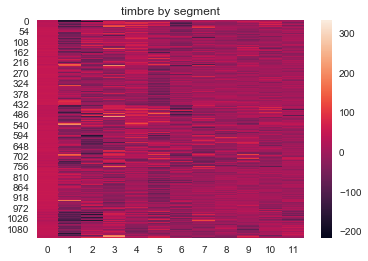

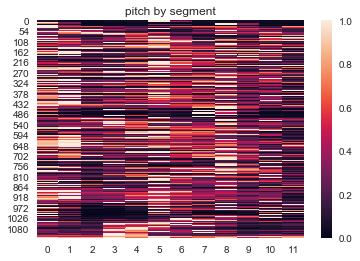

(860, 1130)
[  0.        0.35093   0.76413 ... 271.07252 271.22948 271.3976 ]
[2.2783000e-01 5.4995000e-01 8.7129000e-01 1.1926300e+00 1.5139600e+00
 1.8321600e+00 2.1542800e+00 2.4732700e+00 2.7953900e+00 3.1182900e+00
 3.4370400e+00 3.7508400e+00 4.0646500e+00 4.3784500e+00 4.6922600e+00
 5.0060600e+00 5.3214900e+00 5.6369300e+00 5.9523600e+00 6.2667400e+00
 6.5811200e+00 6.8955000e+00 7.2090400e+00 7.5225700e+00 7.8361100e+00
 8.1496800e+00 8.4633000e+00 8.7769100e+00 9.0905400e+00 9.4041900e+00
 9.7178400e+00 1.0031440e+01 1.0345010e+01 1.0658570e+01 1.0972140e+01
 1.1285820e+01 1.1599510e+01 1.1913200e+01 1.2226750e+01 1.2540310e+01
 1.2853860e+01 1.3167490e+01 1.3481130e+01 1.3794770e+01 1.4108410e+01
 1.4422060e+01 1.4735710e+01 1.5048620e+01 1.5360770e+01 1.5672930e+01
 1.6014160e+01 1.6384480e+01 1.6754790e+01 1.7122480e+01 1.7487550e+01
 1.7852620e+01 1.8213020e+01 1.8573420e+01 1.8933820e+01 1.9248870e+01
 1.9563140e+01 1.9873490e+01 2.0184610e+01 2.0496530e+01 2.0808440e+01

In [168]:
sample_h5 = '/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/G/Y/TRCGYOC128F931E689.h5'
h5 = GETTERS.open_h5_file_read(sample_h5)
timbre = GETTERS.get_segments_timbre(h5)
pitch = GETTERS.get_segments_pitches(h5)
segstarts = GETTERS.get_segments_start(h5)
btstarts = GETTERS.get_beats_start(h5)
duration = GETTERS.get_duration(h5)

bttimbre = get_bttimbre(h5)
h5.close()
print(timbre.shape, pitch.shape)
fig = plt.gcf()
sb.heatmap(timbre)
plt.title('timbre by segment')
plt.show()
sb.heatmap(pitch)
plt.title('pitch by segment')
plt.show()

warpmat = get_time_warp_matrix(segstarts, btstarts, duration)
print(warpmat.shape)
print(segstarts)
print(btstarts)
print(warpmat[0])


In [71]:
# path to the Million Song Dataset subset (uncompressed)
msd_subset_path='/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/'
msd_subset_data_path='/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C'
msd_subset_addf_path=os.path.join(msd_subset_path,'helpers')
msd_code_path='/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/helpers'
sys.path.append(os.path.join(msd_code_path,'PythonSrc') )

import hdf5_getters as GETTERS
def get_bttimbre(h5):
    """
    Get beat-aligned timbre from a song file of the Million Song Dataset
    INPUT:
       h5          - filename or open h5 file
    RETURN:
       bttimbre    - beat-aligned timbre, one beat per column
                     or None if something went wrong (e.g. no beats)
    """    
    timbre = GETTERS.get_segments_timbre(h5)
    segstarts = GETTERS.get_segments_start(h5)
    btstarts = GETTERS.get_beats_start(h5)
    duration = GETTERS.get_duration(h5)
    # get the series of starts for segments and beats
    # NOTE: MAYBE USELESS?
    # result for track: 'TR0002Q11C3FA8332D'
    #    segstarts.shape = (708,)
    #    btstarts.shape = (304,)
    segstarts = np.array(segstarts).flatten()
    btstarts = np.array(btstarts).flatten()
    # aligned features
    bttimbre = align_feats(timbre.T, segstarts, btstarts, duration)
    if bttimbre is None:
        return None
    # done (no renormalization)
    return bttimbre
def get_btloudness(h5):
    loudness = np.array([GETTERS.get_segments_loudness_max(h5)])
    segstarts = GETTERS.get_segments_start(h5)
    btstarts = GETTERS.get_beats_start(h5)
    duration = GETTERS.get_duration(h5)
    segstarts = np.array(segstarts).flatten()
    btstarts = np.array(btstarts).flatten()
    btluudness = align_feats(loudness,segstarts, btstarts, duration)
    if btluudness is None:
        return None
    # done (no renormalization)
    return btluudness
def align_feats(feats, segstarts, btstarts, duration):
    """
    MAIN FUNCTION: aligned whatever matrix of features is passed,
    one column per segment, and interpolate them to get features
    per beat.
    Note that btstarts could be anything, e.g. bar starts
    INPUT
       feats      - matrix of features, one column per segment
       segstarts  - segments starts in seconds,
                    dim must match feats # cols (flatten ndarray)
       btstarts   - beat starts in seconds (flatten ndarray)
       duration   - overall track duration in seconds
    RETURN
       btfeats    - features, one column per beat
                    None if there is a problem
    """
    # sanity check
    if feats.shape[0] == 0 or feats.shape[1] == 0:
        return None
    if btstarts.shape[0] == 0 or segstarts.shape[0] == 0:
        return None

    # FEAT PER BEAT
    # Move segment feature onto a regular grid
    # result for track: 'TR0002Q11C3FA8332D'
    #    warpmat.shape = (304, 708)
    #    btchroma.shape = (304, 12)
    warpmat = get_time_warp_matrix(segstarts, btstarts, duration)
    plt.imshow(warpmat)
    plt.show()
    featchroma = np.dot(warpmat, feats.T).T
    if featchroma.shape[1] == 0: # sanity check
        return None
    # done
    return featchroma

def get_time_warp_matrix(segstart, btstart, duration):
    """
    Used by create_beat_synchro_chromagram
    Returns a matrix (#beats,#segs)
    #segs should be larger than #beats, i.e. many events or segs
    happen in one beat.
    THIS FUNCTION WAS ORIGINALLY CREATED BY RON J. WEISS (Columbia/NYU/Google)
    """
    # length of beats and segments in seconds
    # result for track: 'TR0002Q11C3FA8332D'
    #    seglen.shape = (708,)
    #    btlen.shape = (304,)
    #    duration = 238.91546    meaning approx. 3min59s
    seglen = np.concatenate((segstart[1:], [duration])) - segstart
    btlen = np.concatenate((btstart[1:], [duration])) - btstart

    warpmat = np.zeros((len(segstart), len(btstart)))
    # iterate over beats (columns of warpmat)
    for n in range(len(btstart)):
        # beat start time and end time in seconds
        start = btstart[n]
        end = start + btlen[n]
        # np.nonzero returns index of nonzero elems
        # find first segment that starts after beat starts - 1
        try:
            start_idx = np.nonzero((segstart - start) >= 0)[0][0] - 1
        except IndexError:
            # no segment start after that beats, can happen close
            # to the end, simply ignore, maybe even break?
            # (catching faster than ckecking... it happens rarely?)
            break
        # find first segment that starts after beat ends
        segs_after = np.nonzero((segstart - end) >= 0)[0]
        if segs_after.shape[0] == 0:
            end_idx = start_idx
        else:
            end_idx = segs_after[0]
        # fill col of warpmat with 1 for the elem in between
        # (including start_idx, excluding end_idx)
        warpmat[start_idx:end_idx, n] = 1.
        # if the beat started after the segment, keep the proportion
        # of the segment that is inside the beat
        warpmat[start_idx, n] = 1. - ((start - segstart[start_idx])
                                 / seglen[start_idx])
        # if the segment ended after the beat ended, keep the proportion
        # of the segment that is inside the beat
        if end_idx - 1 > start_idx:
            warpmat[end_idx-1, n] = ((end - segstart[end_idx-1])
                                     / seglen[end_idx-1])
        # normalize so the 'energy' for one beat is one
        warpmat[:, n] /= np.sum(warpmat[:, n])
        return warpmat.T
def get_bttatums(h5):
    tatums = GETTERS.get_tatums_start(h5)
    segstarts = GETTERS.get_segments_start(h5)
    btstarts = GETTERS.get_beats_start(h5)
    duration = GETTERS.get_duration(h5)
    btstarts = np.array(btstarts).flatten()
    numbt = btstarts.shape[0]
    bttatums = np.zeros(numbt)
    i,j = 0,0
    while i < len(tatums):
        while j < len(btstarts) and btstarts[j] < tatums[i] :
            j+=1
        if j < len(btstarts):
            bttatums[j] +=1 
        i += 1
    if bttatums is None:
        return None
    return np.array([bttatums])

def getSamples(basedir):
    X, Y = [],[]
    feature_labels = ['segments_pitch', 
                 'segments_timbre',
                 'segments_loudness_max',
                 'tempo']
    cnt = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*.h5'))
        print(root, cnt)
        # apply function to all files
        for f in files :
#             try:
            h5 = GETTERS.open_h5_file_read(f)
#                 segments_pitch = GETTERS.get_segments_pitches(h5)
#                 segments_timbre = GETTERS.get_segments_timbre(h5)
#                 segments_loudness_max = GETTERS.get_segments_loudness_max(h5)
#                 tempo = GETTERS.get_tempo(h5)
#             except:
#                 h5.close()
#                 print('error')
#                 continue
            year = GETTERS.get_year(h5)
            time_sig = GETTERS.get_time_signature(h5)
        
            if year == 0:
                continue
            bttimbre = get_bttimbre(h5)
            bttatums = get_bttatums(h5)
            btloudness = get_btloudness(h5)
            h5.close()
            if bttimbre is None or bttatums is None or year == 0 or get_btloudness is None:
                continue
            X.append([bttimbre,bttatums,time_sig,get_btloudness])
            Y.append(year)
            cnt+=1
            if cnt  > 10000:
                break;
    return X, Y, feature_labels

X, Y, labels = getSamples(msd_subset_data_path)

/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C 0
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R 0
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/R 0
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/U 30
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/I 63
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/N 103
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/G 127
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/Z 156
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/T 183
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/S 216
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/A 242
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/F 284
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/O 325
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/H 361
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/R/M 401
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/

/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/U 3675
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/I 3701
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/N 3751
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/G 3768
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/Z 3800
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/T 3828
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/S 3863
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/A 3899
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/F 3923
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/O 3953
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/H 3980
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/M 4010
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/J 4048
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/C 4075
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/Z/D 4110
/Users/sw_k_jung/Google D

/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/M/B 7463
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/M/K 7495
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/M/L 7519
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/M/Y 7543
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/M/P 7571
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/M/W 7606
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/J 7638
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/J/R 7638
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/J/U 7672
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/J/I 7697
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/J/N 7724
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/J/G 7755
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/J/Z 7781
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/J/T 7810
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/J/S 7837
/Users/sw_k_jung/Google Dri

/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/E/H 10035
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/E/M 10036
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/E/J 10037
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/E/C 10038
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/E/D 10039
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/E/V 10040
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/E/Q 10041
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/E/X 10042
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/E/E 10043
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/E/B 10044
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/E/K 10045
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/E/L 10046
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/E/Y 10047
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/E/P 10048
/Users/sw_k_jung/Google Drive/Cloud/CSE546/data_train/C/E/W 10049
/Users/sw_

In [72]:
print(len(X), len(Y))

10102 10102


10096 10096
{2000: 5821, 1990: 2462, 1980: 837, 1970: 529, 1960: 226, 1950: 64, 2010: 152, 1940: 5}


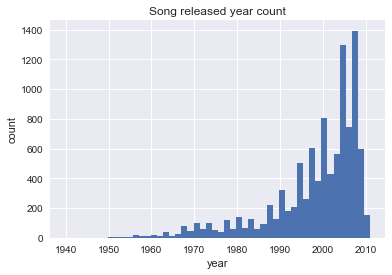

(30, 5)


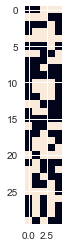

In [85]:
import matplotlib.pyplot as plt
import copy
# Generate a normal distribution, center at x=0 and y=5

X_filtered = []
Y_filtered = []
decades= dict()
for i, year in enumerate(Y):
    if year >= 1940:
        decade = year-(year%10)
        X_filtered.append(X[i])
        Y_filtered.append(Y[i])
        if decade not in decades:
            decades[decade] = 1
        else:
            decades[decade] +=1
print(len(X_filtered),len(Y_filtered))
print(decades)
plt.hist(Y_filtered, bins=50)
plt.xlabel('year')
plt.ylabel('count')
plt.title('Song released year count')
plt.show()

plt.imshow(X_filtered[0][0])
plt.show()

In [131]:
def extract_and_compress(btfeat, npicks, winsize, finaldim, seed=3232343, randproj=None):
    """
    From a btfeat matrix, usually 12xLENGTH
    Extracts 'npicks' windows of size 'winsize' equally spaced
    Flatten these picks, pass them through a random projection, final
    size is 'finaldim'
    Returns matrix npicks x finaldim, or 0 x finaldim if problem
    (btfeats not long enough for instance)
    We could return less than npicks if not long enough!
    For speed, we can compute the random projection once and pass it as an
    argument.
    """
    # features length
    ftlen = btfeat.shape[1]
    ndim = btfeat.shape[0]
    # too small case
    if ftlen < winsize:
        return np.zeros((0, finaldim))
    # random projection
    if randproj is None:
        randproj = RANDPROJ.proj_point5(ndim * winsize, finaldim, seed=seed)
    # not big enough for number of picks, last one too large return just 1
    if ftlen < int(ftlen * (npicks * 1. / (npicks + 1))) + winsize:
        pos = int((ftlen - winsize) / 2.)  # middle
        picks = [btfeat[:, pos:pos + winsize]]
    # regular case, picks will contain npicks
    else:
        picks = []
        for k in range(1, npicks + 1):
            pos = int(ftlen * (k * 1. / (npicks + 1)))
            picks.append(btfeat[:, pos:pos + winsize])

    # # project / compress these
    projections = list(map(lambda x: np.dot(x.flatten(), randproj).reshape(1, finaldim), picks))
    return np.concatenate(projections)

def flatten(X,Y, npicks = 3, winsize = 12, finaldim = 100):
    flattenedX,flattenedY = [],[]
    for i in range(len(X)):
#     for i in range(1):
        x = X[i]
        bttimbre = x[0]
        bttatums = x[1] # ndarray 1 x numbt 
        time_sig = x[2]
        ndim_timbre = bttimbre.shape[0]
        ndim_tatum = bttatums.shape[0]
        numbt = bttatums.shape[1]
#         if time_sig is not None:
#             winsize = time_sig
#             npicks = int(numbt/winsize)
        randproj_timbre = RANDPROJ.proj_point5(ndim_timbre * winsize, finaldim)
#         randproj_tatum = RANDPROJ.proj_point5(ndim_tatum * winsize, finaldim)
        if numbt > npicks:
            processed_timbre = extract_and_compress(bttimbre,npicks,winsize,finaldim,randproj=randproj_timbre)
#             processed_tatum = extract_and_compress(bttatums,npicks,winsize,finaldim,randproj=randproj_tatum)
            processed_feats = []
            for n in range(processed_timbre.shape[0]):
                processed_feats.append(processed_timbre[n])
#                 processed_feats.append(np.concatenate((processed_timbre[n], processed_tatum[n]), axis=None))
            flattenedX =flattenedX+processed_feats
            flattenedY = flattenedY+processed_timbre.shape[0]*[Y[i]]
    return flattenedX, flattenedY


In [132]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
error1, error2 = [], []
for winsize in range(12, 100 ,12):
    print(winsize)
    X_flattened,Y_flattened = flatten(X_filtered, Y_filtered, winsize=winsize) 
    X_train, X_test, y_train, y_test = train_test_split(X_flattened, Y_flattened, test_size=0.2, random_state=42)
    print(np.mean(y_test))
    print('train num', len(y_train), 'test num', len(y_test))

    regr =linear_model.LinearRegression()
    regr.fit(X_train,y_train)
    regr_predict = regr.predict(X_test)
    error  = np.mean(np.abs(y_test - regr_predict))
    error1.append(error)
    print('linear model', error, np.mean(regr_predict) ,np.std(regr_predict))

    knn = KNeighborsClassifier(n_neighbors=50)
    knn.fit(X_train, y_train)
    predicted_years = knn.predict(X_test)
    error  = np.mean(np.abs(y_test - predicted_years))
    error2.append(error)
    print('50 knn', error, np.mean(predicted_years),np.std(predicted_years))
    


12
1998.205298013245
train num 24157 test num 6040
linear model 8.214812908492902 1998.256819969367 2.2737367544323206e-13
50 knn 8.67317880794702 2006.0 0.0
24
1998.3064085447263
train num 23967 test num 5992
linear model 8.152544470550584 1998.2002298650593 2.2737367544323206e-13
50 knn 8.573765020026702 2006.0 0.0
36
1998.2883187035786
train num 23692 test num 5924
linear model 109027846040.14511 -109027844033.69597 8390895231076.621
50 knn 8.598075624577987 2005.9984807562457 0.11692256277723458
48
1998.2407883461867
train num 23337 test num 5835
linear model 8.333296885286964 1998.2067221913167 6.821210263296962e-13
50 knn 7.811825192802057 2003.0 0.0
60


KeyboardInterrupt: 

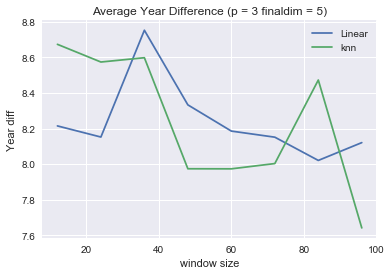

In [130]:
sb.set()
error_linear_winsize = [8.214812908492902, 8.15227288170814, 8.75227288170814, 8.333040678189397, 8.185774048725843, 8.151514970773299, 8.020925244831949, 8.120925244831949]

error_knn_picks = [8.11595639246779, 9.21543461955163, 9.258599963010912, 7.959596288458408, 7.717626463210703, 8.049918034679411, 7.523256070884062, 8.812385580291558, 7.702863873960097, 7.167771141836429, 7.125482745733151, 8.413603337889361, 8.878461602915916, 9.241271393643032, 9.009551590025167, 7.918245980917527, 7.04178421654594, 8.45604683677036, 6.9941921355803105, 8.161047027506655]
error_linear_timbre_tatum = [7.35756079, 7.3006048,7.25981149,7.138917730,7.0551099132,7.013456, 7.01313604411, 6.99913799, 6.99193470, 6.9965110]
error_knn_timbre_tatum = [7.635065134, 6.959632183, 6.55846743, 6.18620689, 6.1499157088, 6.1336091954, 6.01063601, 6.08429118, 5.9637088122, 5.955800766]
# plt.plot(np.arange(1, 100,5), error1)
plt.plot(np.arange(12, 100 ,12), error_linear_winsize, label = 'Linear')
plt.plot(np.arange(12, 100 ,12), error2, label= 'knn')
# plt.plot(np.arange(1, 100,10), error_linear_timbre_tatum, label = 'Timbre+Tatum (Linear)')
# plt.plot(np.arange(1, 100,10), error_knn_timbre_tatum, label= 'Timbre+Tatum (knn)')
plt.legend()
plt.xlabel('window size')
plt.ylabel('Year diff')
plt.title(r'Average Year Difference (p = 3 finaldim = 5)')
plt.show()

In [128]:
print(error1)

[8.214812908492902, 8.15227288170814, 150848489152.68402, 8.333040678189397, 8.185774048725843, 8.151514970773299, 8.020925244831949, 634942741654.5823]


In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=1000)
mlp.fit(X_train,y_train)


In [ ]:
class Net_cnn(nn.Module):
    def __init__(self, M=100, p = 5, N = 14):
        super(Net_cnn, self).__init__()
        self.conv = nn.Conv2d(3, M, p)
        self.max_pool = nn.MaxPool2d(N,N)
        self.last_dimension = int(M*(((33-p)/N)**2))
        self.fc = nn.Linear(self.last_dimension, 10)
    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = x.view(-1,self.last_dimension) #reshaping. 
        x = self.fc(x)
        return x
net = Net_cnn()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10
train_accuracy = []
test_accuracy = []
for epoch in range(num_ephochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    train_acc = compute_accuracy(trainloader)
    test_acc = compute_accuracy(testloader)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    print(train_acc, test_acc)